In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm import tqdm

In [2]:
%load_ext cython

In [3]:
L = 5000
N = 15
drop = 5000
calc = 10000

In [4]:
def analyze(evolve, drop, calc, N, L, begin, end, n):
    all_d = []
    for p in np.linspace(.01, .9, 10):
        np.random.seed(42)
        _field_ = np.random.choice((0, 1), (N, L), p=(1-p, p))
        densities = []
        for b in tqdm(np.linspace(begin, end, n), total=n):
            d = []
            for i in range(N):
                dens = 0
                field = _field_[i].copy()
                field = evolve(field, b, drop)
                for _ in range(calc-drop):
                    field = evolve(field, b)
                    dens += field.sum()/(1.*L)
                dens = dens/(calc-drop)
                d.append(dens)
            densities.append(d)
        all_d.append(densities)
    return np.asarray(all_d)

In [5]:
def mean_wo_zeros(densities, L):
    result = []
    assert densities.ndim == 3
    for dens in densities:
        res = []
        for d in dens:
            if (d < 1/(2.*L)).all():
                res.append(0.)
            else:
                res.append(d[d > 1/(2.*L)].mean())
        result.append(res)
    return np.asarray(result)


def std_wo_zeros(densities, L):
    result = []
    assert densities.ndim == 3
    for dens in densities:
        res = []
        for d in dens:
            if (d < 1/(2.*L)).all():
                res.append(0.)
            else:
                res.append(d[d > 1/(2.*L)].std())
        result.append(res)
    return np.asarray(result)

In [6]:
def mean_wo_zeros2D(densities, L):
    result = []
    assert densities.ndim == 2
    for d in densities:
        if (d < 1/(2.*L)).all():
            result.append(0.)
        else:
            result.append(d[d > 1/(2.*L)].mean())
    return np.asarray(result)


def std_wo_zeros2D(densities, L):
    result = []
    assert densities.ndim == 2
    for d in densities:
        if (d < 1/(2.*L)).all():
            result.append(0.)
        else:
            result.append(d[d > 1/(2.*L)].std())
    return np.asarray(result)

# Novak-May game

In [6]:
begin = .9
end = 3
n = 20

In [12]:
%%cython

import numpy as np

import cython
@cython.cdivision(True)
@cython.boundscheck(False)
def evolve_nm(long[:] field, double b, int num_steps=1):
    
    cdef:
        int x, y, L, i, j, ix, jy, step
        double density
    
    L = field.shape[0]
    cdef double[:] scores = np.zeros((L), dtype=float)
    
    cdef double[:] _zeros = np.zeros((L), dtype=float)
    cdef long[:] current = field.copy()
    
    for step in range(num_steps):
        current = field.copy()
        scores[...] = _zeros
        
        for x in range(L):
            for i in range(-1, 2):
                ix = (x + i) % L
                scores[x] += field[ix]
            
            if field[x] == 0:
                scores[x] *= b
        
        for x in range(L):
            bestX = x
            for i in range(-1, 2):
                ix = (x + i) % L
                if (scores[bestX] < scores[ix]):
                    bestX = ix

            field[x] = current[bestX]
    return np.asarray(field)

@cython.cdivision(True)
@cython.boundscheck(False)
def score_nm(long[:] field, double b):
    
    cdef:
        int x, y, L, i, j, ix, jy, step
        double density
    
    L = field.shape[0]
    cdef double[:] scores = np.zeros((L), dtype=float)
    
    cdef double[:] _zeros = np.zeros((L), dtype=float)
    cdef long[:] current = field.copy()

    for x in range(L):
        for i in range(-1, 2):
            ix = (x + i) % L
            scores[x] += field[ix]

        if field[x] == 0:
            scores[x] *= b

    return np.asarray(scores)

In [8]:
try:
    densities = np.load("nm1d.npy")
except FileNotFoundError:
    densities = analyze(evolve_nm, drop, calc, N, L, begin, end, n)
    np.save("nm1d.npy", densities)

In [9]:
dens = mean_wo_zeros(densities, L)
std = std_wo_zeros(densities, L)

<IPython.core.display.Javascript object>


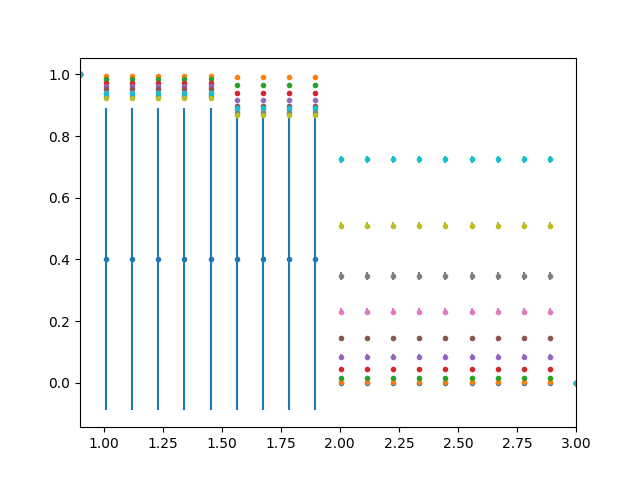

In [10]:
# fig = plt.figure()
plt.xlim(begin, end)
for i in range(10):
    plt.errorbar(np.linspace(begin, end, n), densities[i].mean(axis=-1), yerr=densities[i].std(axis=-1), fmt=".")
# plt.show()

### Without fields that have dropped to 0

<IPython.core.display.Javascript object>


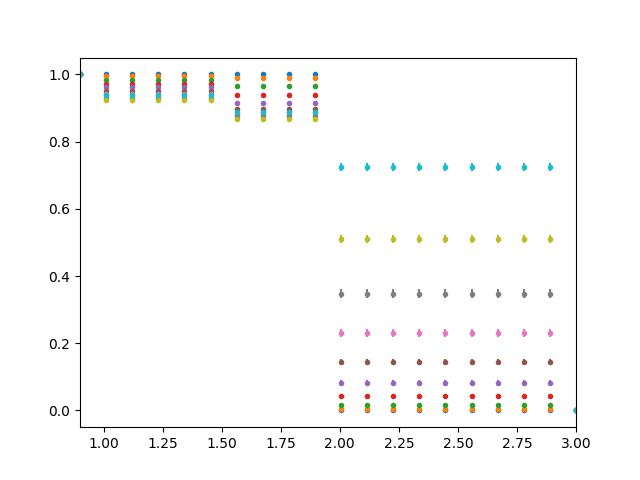

In [11]:
fig = plt.figure()
plt.xlim(begin, end)
for i in range(10):
    plt.errorbar(np.linspace(begin, end, n), dens[i], yerr=std[i], fmt=".")
plt.show()

<IPython.core.display.Javascript object>


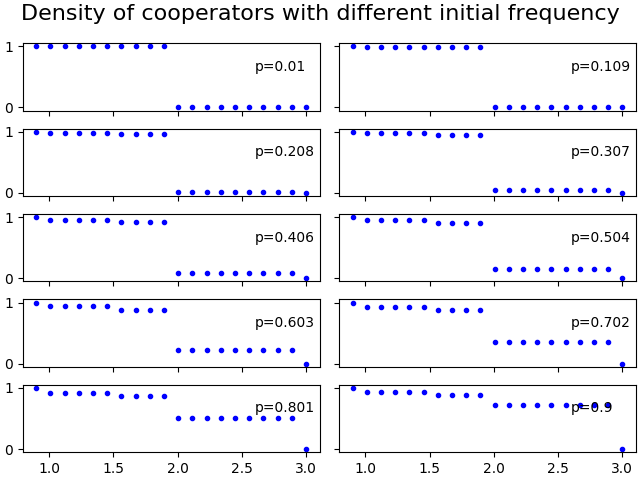

In [12]:
fig, axs = plt.subplots(5, 2, constrained_layout=True, sharex=True, sharey=True)
fig.suptitle('Density of cooperators with different initial frequency', fontsize=16)
for i, p in enumerate(np.linspace(.01, .9, 10)):
    axs[i//2, i%2].errorbar(np.linspace(begin, end, n), dens[i], yerr=std[i], fmt="b.")
    axs[i//2, i % 2].text(end-.4, 0.6, "p={:.3}".format(p, fontsize=11))

plt.show()

# Mean field game

In [13]:
begin = .9
end = 2
n = 20

In [14]:
%%cython

import numpy as np

import cython

@cython.cdivision(True)
@cython.boundscheck(False)
def ssum(long[:] array, long L):
    
    cdef long s = 0
    
    for i in range(L):
        s += array[i]
    return s

@cython.cdivision(True)
@cython.boundscheck(False)
def evolve_mean(long[:] field, double b, int num_steps=1):
    
    cdef:
        int x, y, L, i, j, ix, jy, step
        double density
    
    L = field.shape[0]
    cdef double[:] scores = np.zeros((L), dtype=float)
    
    cdef double[:] _zeros = np.zeros((L), dtype=float)
    cdef long[:] current = field.copy()
    
    for step in range(num_steps):
        current = field.copy()
        scores[...] = _zeros
        density = ssum(field, L)/(1.*L)
        
        for x in range(L):
            for i in range(-1, 2, 2):
                ix = (x + i) % L
                scores[x] += field[ix]
            
            scores[x] += density
            if field[x] == 0:
                scores[x] *= b
        
        for x in range(L):
            bestX = x
            for i in range(-1, 2, 2):
                ix = (x + i) % L
                if (scores[bestX] < scores[ix]):
                    bestX = ix

            field[x] = current[bestX]
    return np.asarray(field)

In [15]:
try:
    densities = np.load("mean1d.npy")
except FileNotFoundError:
    densities = analyze(evolve_mean, drop, calc, N, L, begin, end, n)
    np.save("mean1d.npy", densities)

In [16]:
f_cs = np.linspace(0, 1, 20)

def trans_val(f_c, m, n, i):
    return (m+i+f_c)/(n+i+f_c)

trans = []

for m in range(2):
    for j in range(2):
        for i in range(2):
            trans.append(trans_val(f_cs, m, j, i))

trans = np.asarray(trans)

/home/admitri/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/home/admitri/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


In [17]:
dens = mean_wo_zeros(densities, L)
std = std_wo_zeros(densities, L)

<IPython.core.display.Javascript object>


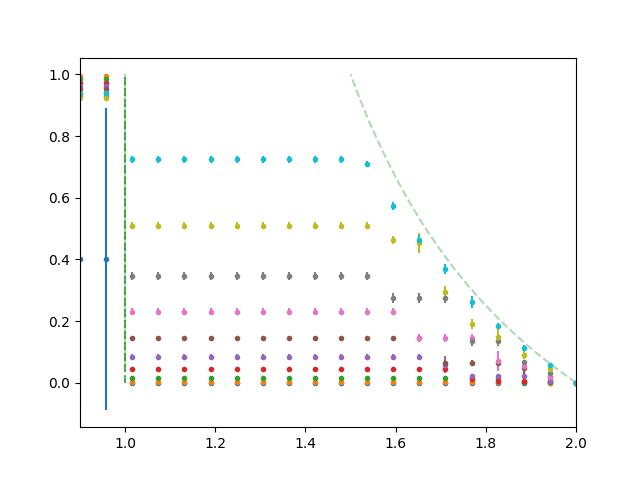

In [18]:
fig  = plt.figure()
plt.xlim(begin, end)
for i in range(10):
    plt.errorbar(np.linspace(begin, end, n), densities[i].mean(axis=-1), yerr=densities[i].std(axis=-1), fmt=".")
for tr in trans:
    plt.plot(tr, f_cs, "g--", alpha=.3)
plt.show()

### Without fields that have dropped to 0

<IPython.core.display.Javascript object>


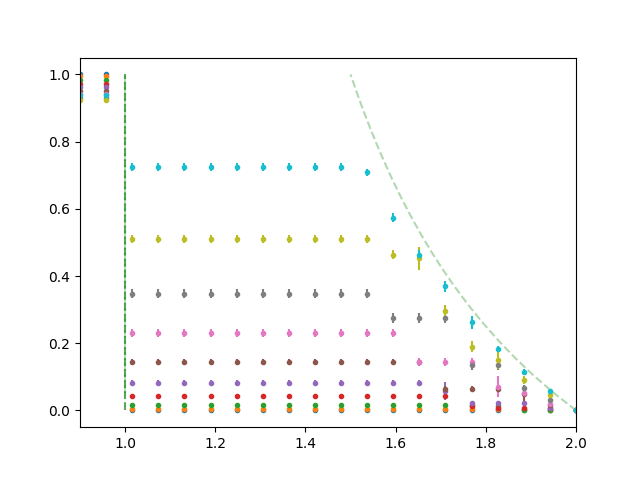

In [19]:
fig = plt.figure()
plt.xlim(begin, end)
for i in range(10):
    plt.errorbar(np.linspace(begin, end, n), dens[i], yerr=std[i], fmt=".")
for tr in trans:
    plt.plot(tr, f_cs, "g--", alpha=.3)
plt.show()

<IPython.core.display.Javascript object>


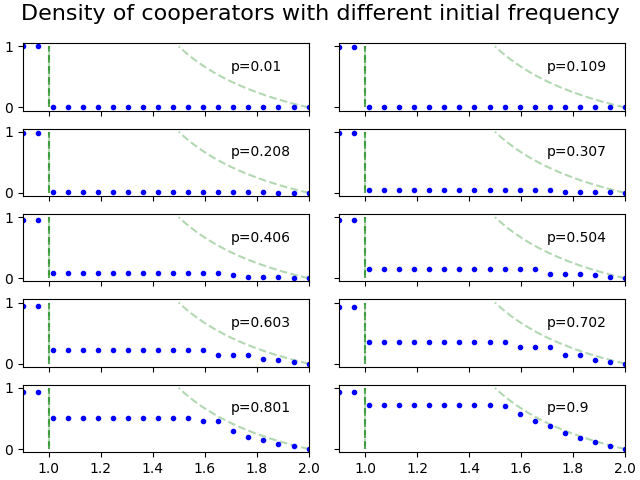

In [20]:
fig, axs = plt.subplots(5, 2, constrained_layout=True, sharex=True, sharey=True)
fig.suptitle('Density of cooperators with different initial frequency', fontsize=16)
for i, p in enumerate(np.linspace(.01, .9, 10)):
    plt.xlim(begin, end)
    axs[i//2, i%2].errorbar(np.linspace(begin, end, n), dens[i], yerr=std[i], fmt="b.")
    for tr in trans:
        axs[i//2, i % 2].plot(tr, f_cs, "g--", alpha=.3)
    axs[i//2, i % 2].text(end-.3, 0.6, "p={:.3}".format(p, fontsize=11))

plt.show()

# Animation

<IPython.core.display.Javascript object>


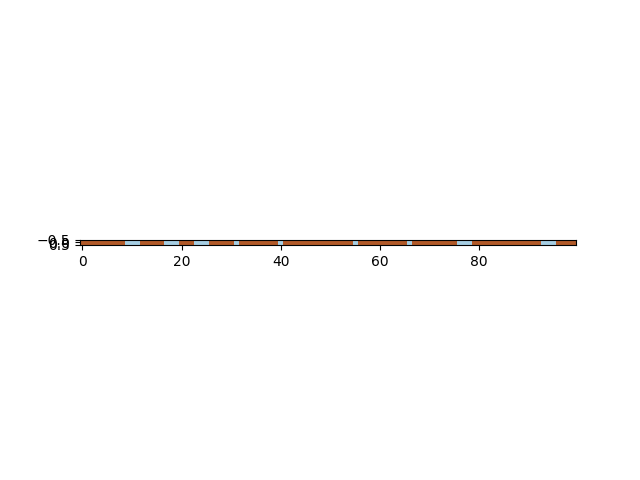

In [22]:
p = .6
L = 100
b = 1.7
field = np.random.choice((0, 1), L, p=(1-p, p))
# field = np.array([1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1], dtype=int)

fig = plt.figure()
im = plt.imshow(field.reshape([1, -1]), animated=True, cmap=plt.get_cmap('Paired'))
# ax.grid(False)
def updatefig(frame):
    if frame < 3:
        return im,
    global field
    field = evolve_nm(field, b, 1)
    im.set_array(field.reshape([1, -1]))
    return im,

# animate!
anim = animation.FuncAnimation(fig, updatefig, frames=100, interval=150, blit=True)

# Let's check if the formula for density works
\begin{align}
            f_c = 0,\quad & 1/2 < b < 1,\;f_0 = 1/2\textit{ and agents are placed through one}\\
            f_c = 1,\quad & b < 1\\
            f_c = 1 - \frac{N_{D}}{L},\quad & 1 < b < \frac{3}{2}\\
            1 - \frac{3N_{D}}{L} \leq f_c \leq 1 - \frac{N_{D}}{L},\quad & \frac{3}{2} < b < 2\\
            f_c = f_0 - \frac{N_C}{L},\quad & 2 < b < 3\\
            0,\quad & b > 3
\end{align}
where
\begin{align*}
    f_c&\text{ - density of cooperators}\\
    f_0&\text{ - density of cooperators at the beginning}\\
    L&\text{ - total number of agents}\\
    N_{D}&\text{ - the number of defector clusters with an odd number of agents on the second step}\\
    N_{C}&\text{ - the number of cooperators in clusters of the size not greater than 2 on the second step}\\
\end{align*}

In [23]:
def generate_field():
    n_clust = np.random.randint(1, 100)
    clust_sizes = np.random.randint(3, 20, 2*n_clust)
    field = np.array([], dtype=int)
    for i, s in enumerate(clust_sizes):
        if i%2 == 0:
            field = np.concatenate((field, np.zeros(s, dtype=int)))
        else:
            field = np.concatenate((field, np.ones(s, dtype=int)))
    return clust_sizes, field

## 1 < b < 3/2

In [24]:
failed = []
for _ in tqdm(range(100)):
    clust_sizes, field = generate_field()
    b = np.random.randint(101, 150)/100.
    L = field.size
    nd = (clust_sizes[::2]%2 == 1).sum()
    field = evolve_nm(field, b, 5000)
    for _ in range(50):
        field = evolve_nm(field, b, 1)
        dens = field.sum()/(1.*L)
        if np.abs(dens - (1 - nd/(1.*L))) >= 1./L: # because we compare floats
            raise ValueError("Failed")
            break
    del field, clust_sizes

100%|██████████| 100/100 [00:33<00:00,  2.99it/s]


## 3/2 < b < 2

In [25]:
failed = []
for _ in tqdm(range(100)):
    clust_sizes, field = generate_field()
    b = 1.7
    L = field.size
    n = (clust_sizes[::2]%2 == 1).sum()
    field = evolve_nm(field, b, 5000)
    for _ in range(50):
        field = evolve_nm(field, b, 1)
        dens = field.sum()/(1.*L)
        if dens - (1 - 3*n/(1.*L)) < 0  or dens - (1 - n/(1.*L))> 1./L: # because we compare floats
            raise ValueError("Failed")
            break
    del field, clust_sizes

100%|██████████| 100/100 [00:32<00:00,  3.11it/s]


## 2 < b < 3

In [26]:
failed = []
for _ in tqdm(range(100)):
    clust_sizes, field = generate_field()
    b = 2.3
    L = field.size
    dens_0 = field.sum()/L
    field = evolve_nm(field, b, 5000)
    for _ in range(50):
        field = evolve_nm(field, b, 1)
        dens = field.sum()/(1.*L)
        if np.abs(dens - dens_0) >= 1./L: # because we compare floats
            raise ValueError("Failed")
            break
    del field, clust_sizes

100%|██████████| 100/100 [00:32<00:00,  2.70it/s]


## b = 2.5

In [9]:
density = np.load("data/1d25stat.npy").reshape((10, -1))

<IPython.core.display.Javascript object>


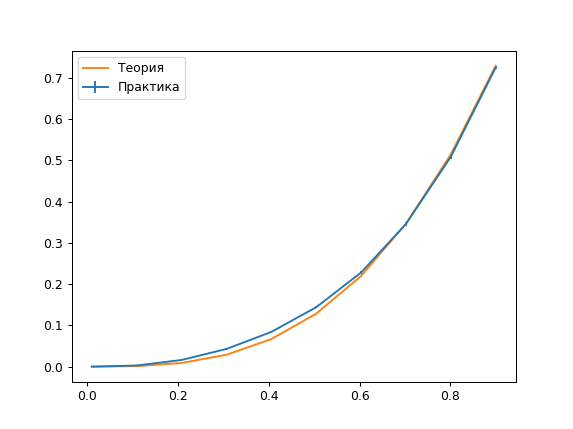

In [24]:
plt.errorbar(np.linspace(.01, .9, 10), density.mean(axis = -1), yerr=density.std(axis=-1), label="Практика")
plt.plot(np.linspace(.01, .9, 10), np.linspace(.01, .9, 10) - (1-np.linspace(.01, .9, 10))*np.linspace(.01, .9, 10)*(1+np.linspace(.01, .9, 10)), label="Теория")
plt.legend()

<IPython.core.display.Javascript object>


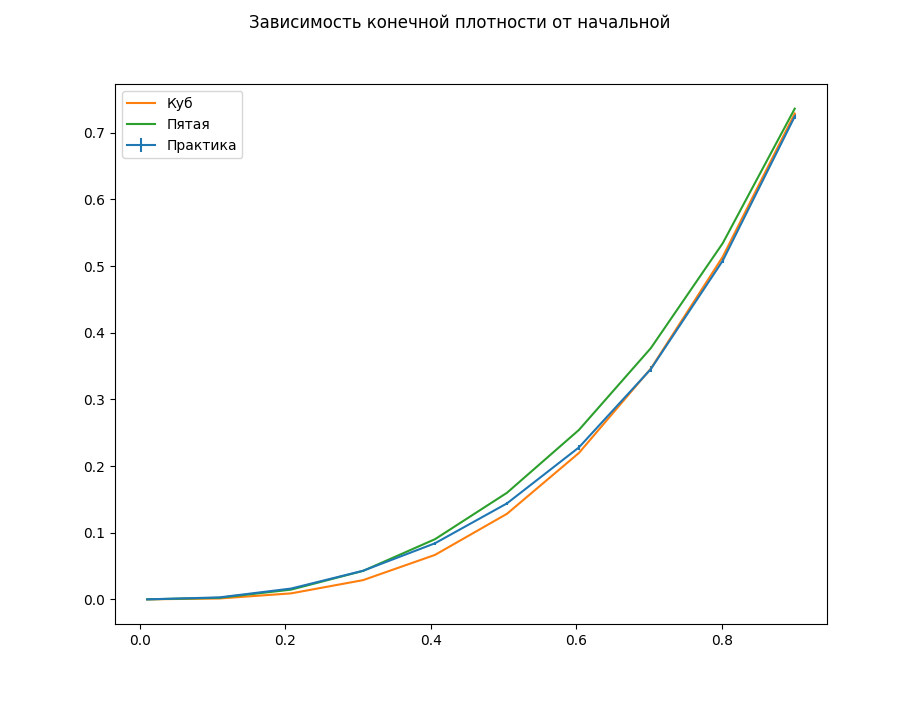

In [16]:
plt.suptitle("Зависимость конечной плотности от начальной")
plt.errorbar(np.linspace(.01, .9, 10), density.mean(axis = -1), yerr=density.std(axis=-1), label="Практика")
plt.plot(np.linspace(.01, .9, 10), np.linspace(.01, .9, 10)**3, label="Куб")
plt.plot(np.linspace(.01, .9, 10), 2*np.linspace(.01, .9, 10)**3 - 2*np.linspace(.01, .9, 10)**4 + np.linspace(.01, .9, 10)**5, label="Пятая")
plt.legend()

<IPython.core.display.Javascript object>


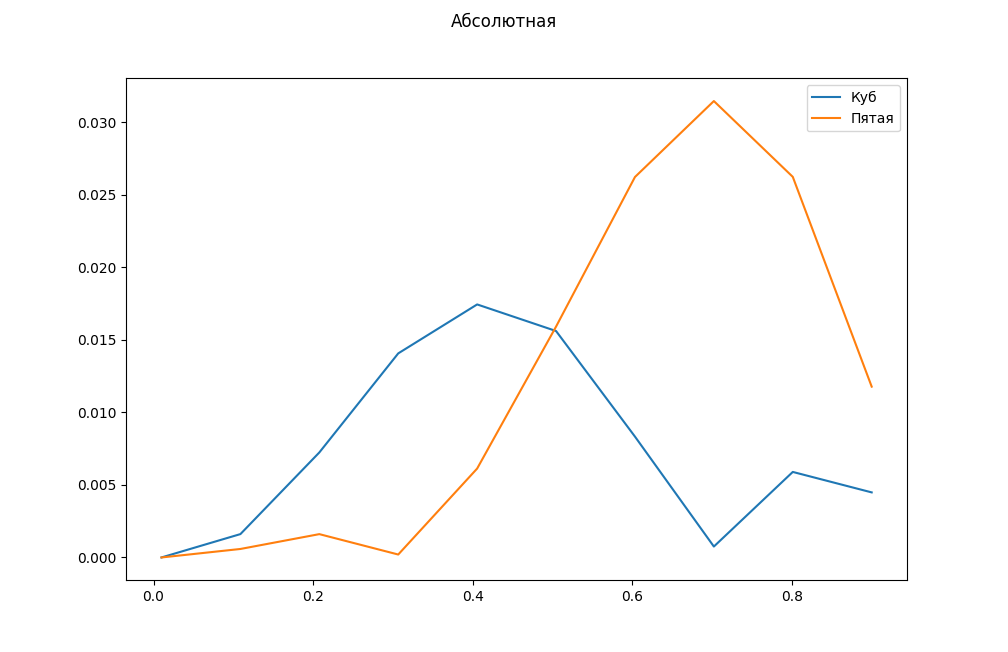

In [18]:
plt.suptitle("Абсолютная")
plt.plot(np.linspace(.01, .9, 10), np.abs(density.mean(axis=-1) - np.linspace(.01, .9, 10)**3), label="Куб")
plt.plot(np.linspace(.01, .9, 10), np.abs(density.mean(axis=-1) - (2*np.linspace(.01, .9, 10)**3 - 2*np.linspace(.01, .9, 10)**4 + np.linspace(.01, .9, 10)**5)), label="Пятая")
plt.legend()

<IPython.core.display.Javascript object>


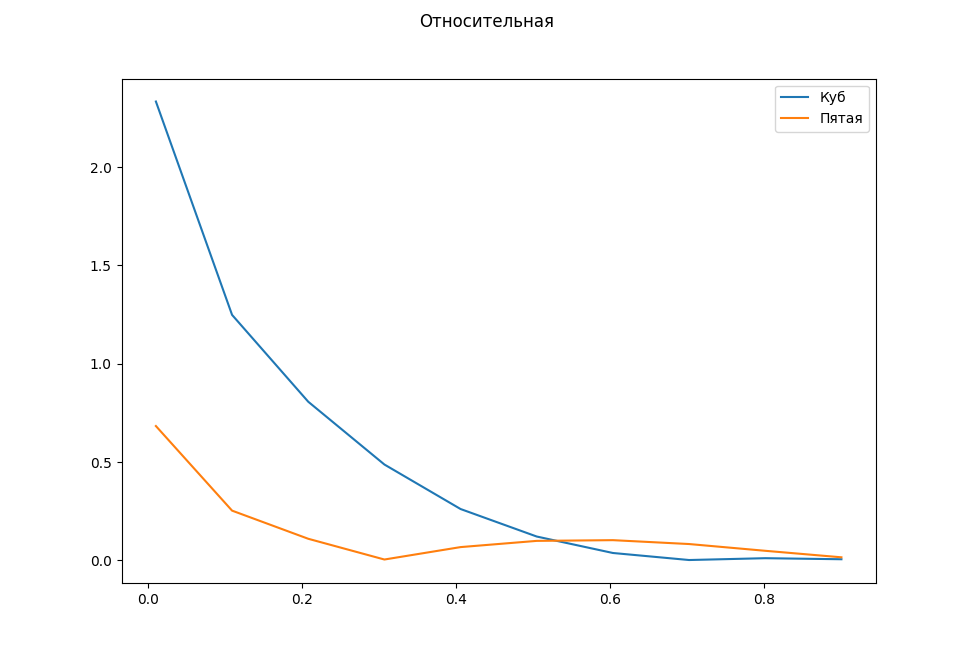

In [19]:
plt.suptitle("Относительная")
plt.plot(np.linspace(.01, .9, 10), np.abs(density.mean(axis=-1) - np.linspace(.01, .9, 10)**3)/np.linspace(.01, .9, 10)**3, label="Куб")
plt.plot(np.linspace(.01, .9, 10), np.abs(density.mean(axis=-1) - (2*np.linspace(.01, .9, 10)**3 - 2*np.linspace(.01, .9, 10)**4 + np.linspace(.01, .9, 10)**5))/(2*np.linspace(.01, .9, 10)**3 - 2*np.linspace(.01, .9, 10)**4 + np.linspace(.01, .9, 10)**5), label="Пятая")
plt.legend()

In [21]:
print(",\n".join(map(lambda xy: "{" + "{:.4f},{:.4f}".format(*xy) + "}", zip(np.linspace(.01, .9, 10), density.mean(axis = -1)))),)

{0.0100,0.0000},
{0.1089,0.0029},
{0.2078,0.0162},
{0.3067,0.0429},
{0.4056,0.0841},
{0.5044,0.1440},
{0.6033,0.2280},
{0.7022,0.3455},
{0.8011,0.5082},
{0.9000,0.7245}


$$-0.00128259 + 0.159322 r - 3.43606 r^2 + 34.5623 r^3 - 162.754 r^4 + 
 457.25 r^5 - 782.329 r^6 + 800.703 r^7 - 449.108 r^8 + 105.997 r^9$$

## b = 1.2

In [25]:
density = np.load("data/1d12stat.npy").reshape((10, -1))

<IPython.core.display.Javascript object>


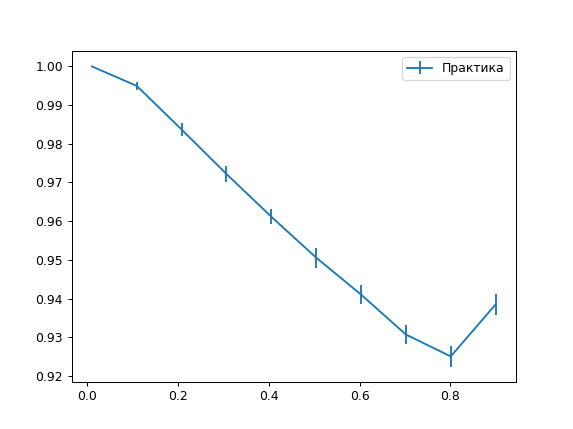

In [26]:
plt.errorbar(np.linspace(.01, .9, 10), mean_wo_zeros2D(density, 50000), yerr=std_wo_zeros2D(density, 50000), label="Практика")
plt.legend()

In [28]:
print(",\n".join(map(lambda xy: "{" + "{:.4f},{:.4f}".format(*xy) + "}", zip(np.linspace(.01, .9, 10), mean_wo_zeros2D(density, 50000)))),)

{0.0100,0.9999},
{0.1089,0.9949},
{0.2078,0.9836},
{0.3067,0.9722},
{0.4056,0.9611},
{0.5044,0.9506},
{0.6033,0.9411},
{0.7022,0.9308},
{0.8011,0.9251},
{0.9000,0.9385}


$$1.00018 - 0.0343757 r + 0.740957 r^2 - 16.1167 r^3 + 107.258 r^4 - 
 371.693 r^5 + 743.35 r^6 - 861.356 r^7 + 535.979 r^8 - 138.24 r^9$$

## b = 1.7

In [30]:
density = np.load("data/1d17stat.npy").reshape((10, -1))

<IPython.core.display.Javascript object>


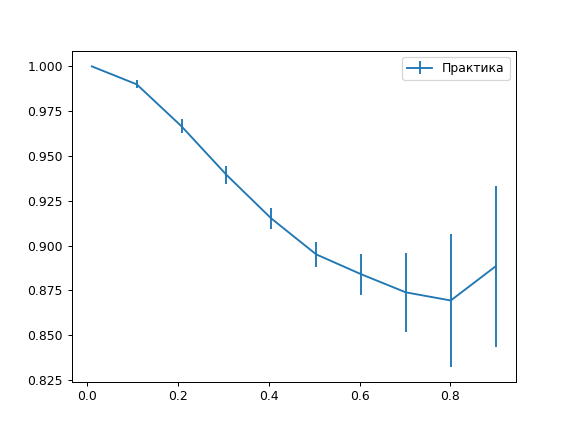

In [31]:
# plt.errorbar(np.linspace(.01, .9, 10), densities.mean(axis = -1), yerr=densities.std(axis=-1), label="Практика 1")
plt.errorbar(np.linspace(.01, .9, 10), mean_wo_zeros2D(density, 50000), yerr=std_wo_zeros2D(density, 50000), label="Практика")
# plt.plot(np.linspace(.01, .9, 10), 1 - (1 - np.linspace(.01, .9, 10))/(2 - np.linspace(.01, .9, 10)), label="Теория")
plt.legend()

In [32]:
print(",\n".join(map(lambda xy: "{" + "{:.4f},{:.4f}".format(*xy) + "}", zip(np.linspace(.01, .9, 10), mean_wo_zeros2D(density, 50000)))),)

{0.0100,0.9998},
{0.1089,0.9898},
{0.2078,0.9664},
{0.3067,0.9394},
{0.4056,0.9151},
{0.5044,0.8951},
{0.6033,0.8840},
{0.7022,0.8739},
{0.8011,0.8694},
{0.9000,0.8884}


$$1.00528 - 0.67829 r + 14.409 r^2 - 148.903 r^3 + 779.196 r^4 - 
 2362.79 r^5 + 4320.58 r^6 - 4687.3 r^7 + 2772.95 r^8 - 687.967 r^9$$